In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
import pei.laborfunctions as lf
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from dask.diagnostics import ProgressBar

# Load Data

## Capacity Data

In [2]:
# Load ESM2M labor capacity data
ds_cesm2 = xr.open_mfdataset('../data/processed/CESM2/Monthly_Capacity/*',combine='nested',concat_dim='ensemble',chunks={'time':1000}).rename({'__xarray_dataarray_variable__':'capacity'})

In [3]:
# Calculate 1980-2000 baseline by month
with ProgressBar():
    ds_base = lf.calc_baseline(ds_cesm2).compute()

[########################################] | 100% Completed | 48.3s


In [4]:
# Shorten capacity dataset to 2000-2100
ds_cesm2 = ds_cesm2.sel(time=slice('2000-01-31',None))['capacity']

## Population/Land Area Data

In [5]:
# Population data
ds_pop = xr.open_dataset('../data/processed/CESM2/population_regrid_cesm2.nc')['population']
ds_pop = ds_pop.where(np.isfinite(ds_pop),0)
ds_pop = ds_pop.rename({'latitude':'lat','longitude':'lon'})

In [6]:
# Load area data
land_area = xr.open_dataset('../data/processed/CESM2/cesm2.land_area')['__xarray_dataarray_variable__']
land_mask = np.isfinite(land_area)
# Replace NaN with 0 
land_area_adj = land_area.where(land_mask,0).isel(ensemble=0)

## Calculate ToEs

In [7]:
# Labor reduction thresholds and frequency threshold (# reduced months per year) used to define ToE
labor_thres = [0.9,0.8,0.7]
freq_thres = 3

with ProgressBar():
    # Calculate ToEs for all grid cells and ensemble members
    ds_toe = lf.toe(ds_cesm2,ds_base,labor_thres,freq_thres).compute()

[########################################] | 100% Completed |  3min 47.5s
[########################################] | 100% Completed |  2.0s
[########################################] | 100% Completed |  2.0s


# Map Baseline Capacity

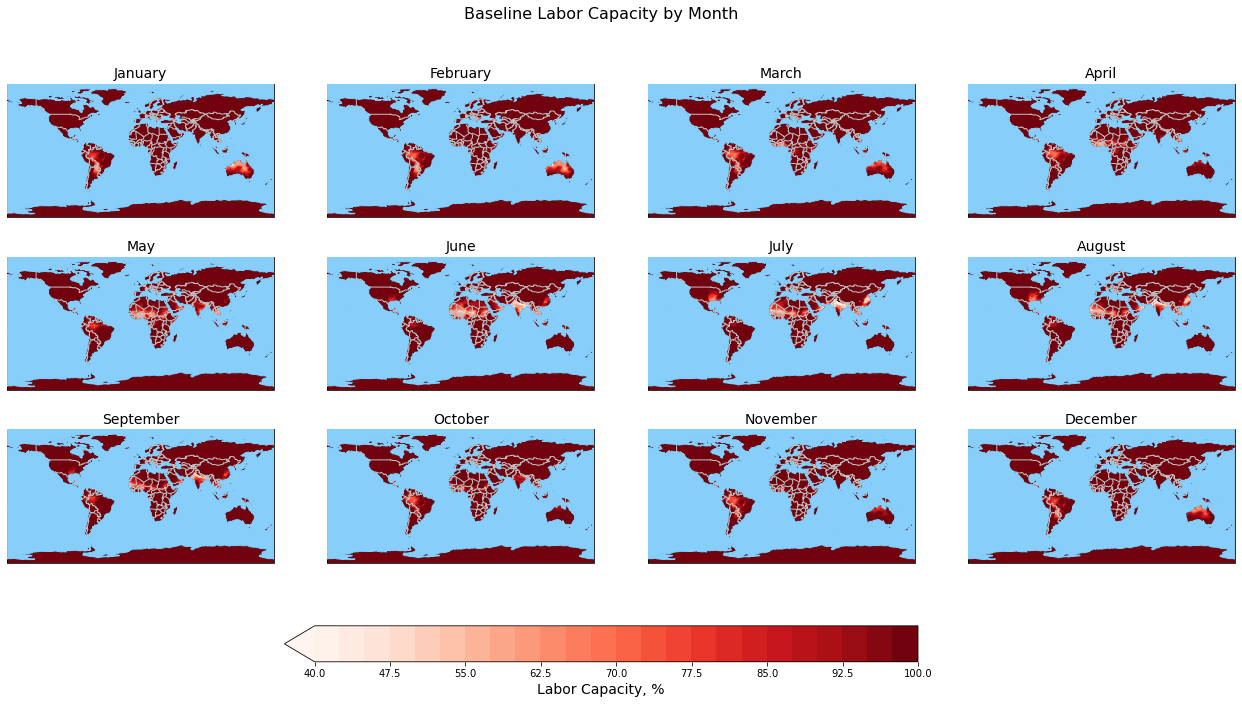

In [21]:
# Specify projection
crs = ccrs.PlateCarree()

# Create figure and axes
fig, axs = plt.subplots(ncols=4,nrows=3,figsize=(22,10),subplot_kw={'projection':crs})

levels = np.linspace(40,100,25)
cmap = 'Reds'
months = ['January','February','March','April','May','June','July','August','September','October','November','December']

for index in range(12):
    # Get correct axis
    ax = axs[int(index/4)][index%4]
    
    im = lf.contour(ds_base.isel(month=index),months[index],ax,levels=levels,cmap =cmap,label='Year',extend='min')
    index+=1

# Single colorbar for all plots
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.3, 0.07, 0.4, 0.05])
cbar = fig.colorbar(im, cax=cbar_ax,orientation='horizontal');
cbar.set_label('Labor Capacity, %',fontsize=14)

# Overall figure title
fig.suptitle('Baseline Labor Capacity by Month',fontsize=16);

# ToE Plots

## Spatial Maps

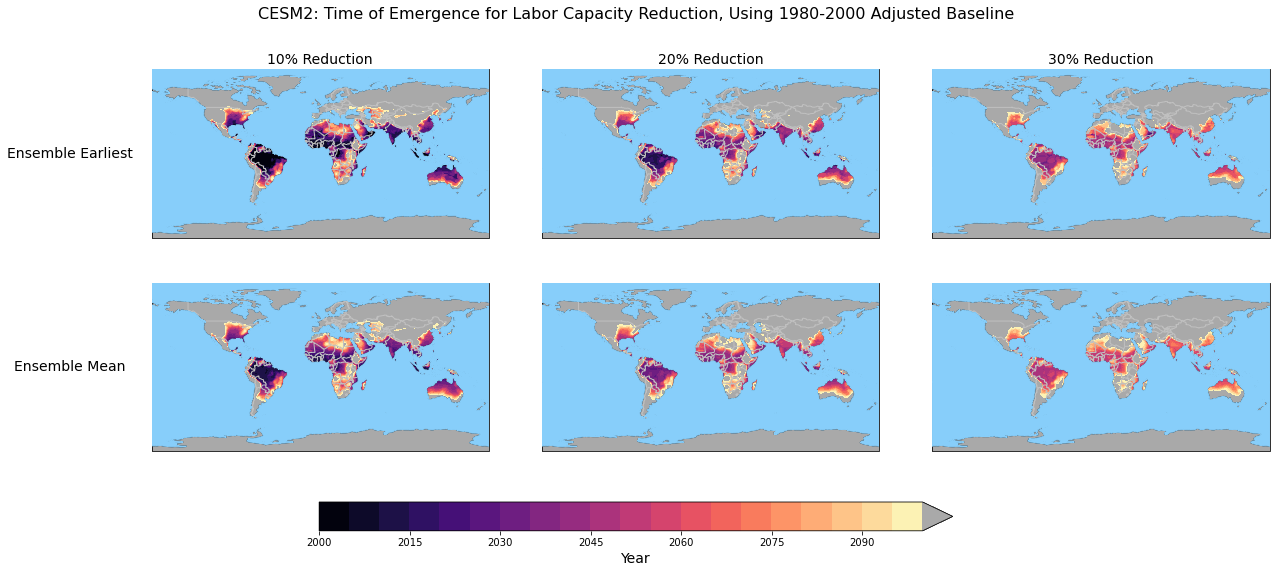

In [24]:
lf.spatial_toe(ds_toe,'CESM2: Time of Emergence for Labor Capacity Reduction, Using 1980-2000 Adjusted Baseline')

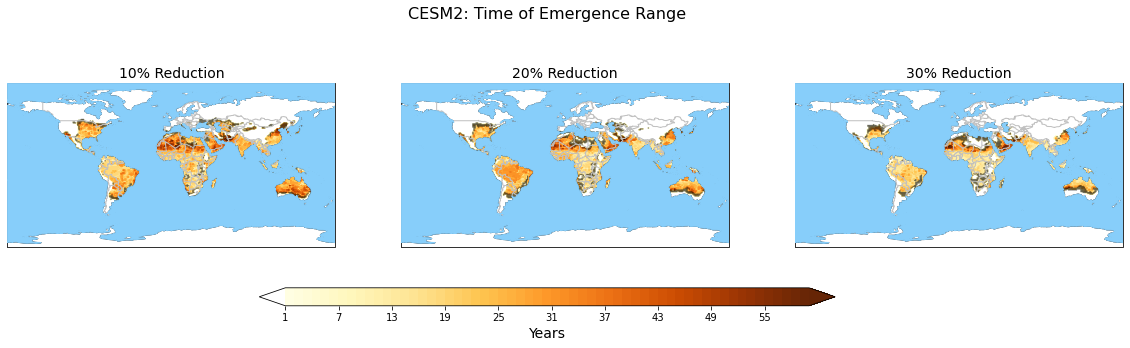

In [45]:
lf.spatial_toe_diff(ds_toe,'CESM2: Time of Emergence Range')

## Bar Charts

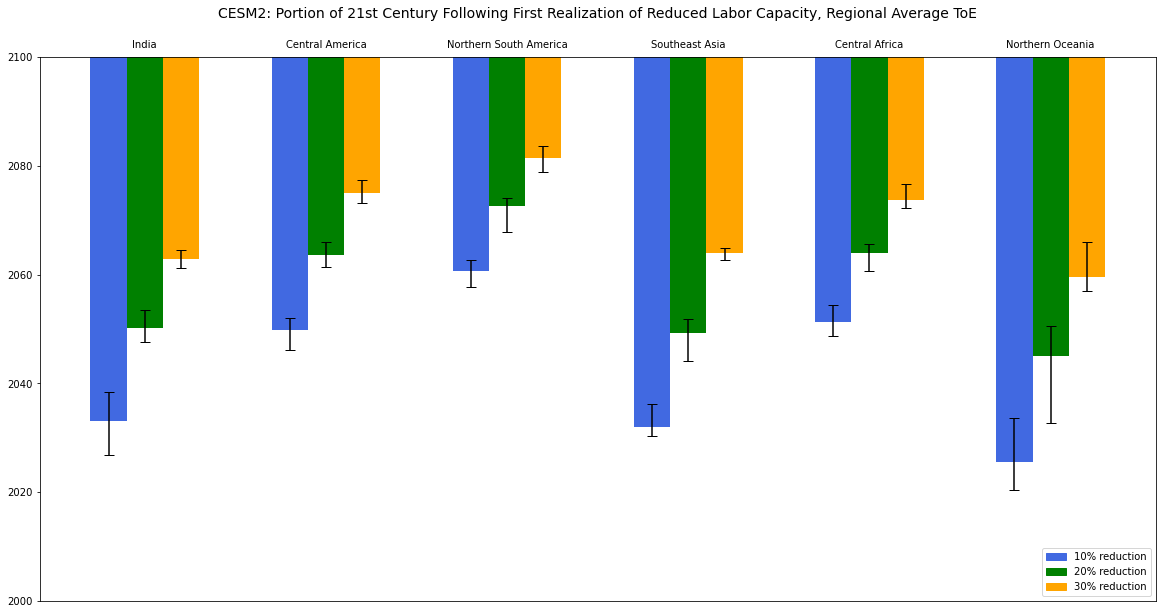

In [27]:
lf.average_toe_bar(ds_toe,ds_pop,'CESM2','CESM2: Portion of 21st Century Following First Realization of Reduced Labor Capacity, Regional Average ToE\n')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16.7 µs


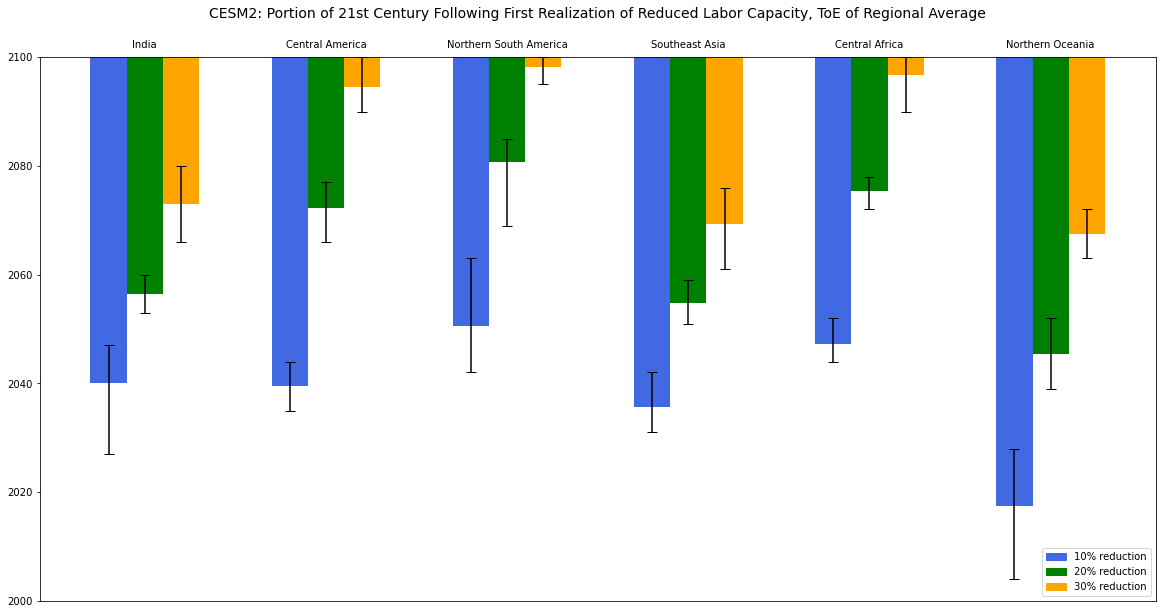

In [29]:
lf.toe_bar(ds_cesm2,ds_base,ds_pop,'CESM2','CESM2: Portion of 21st Century Following First Realization of Reduced Labor Capacity, ToE of Regional Average\n',labor_thres,freq_thres)

# Time Series

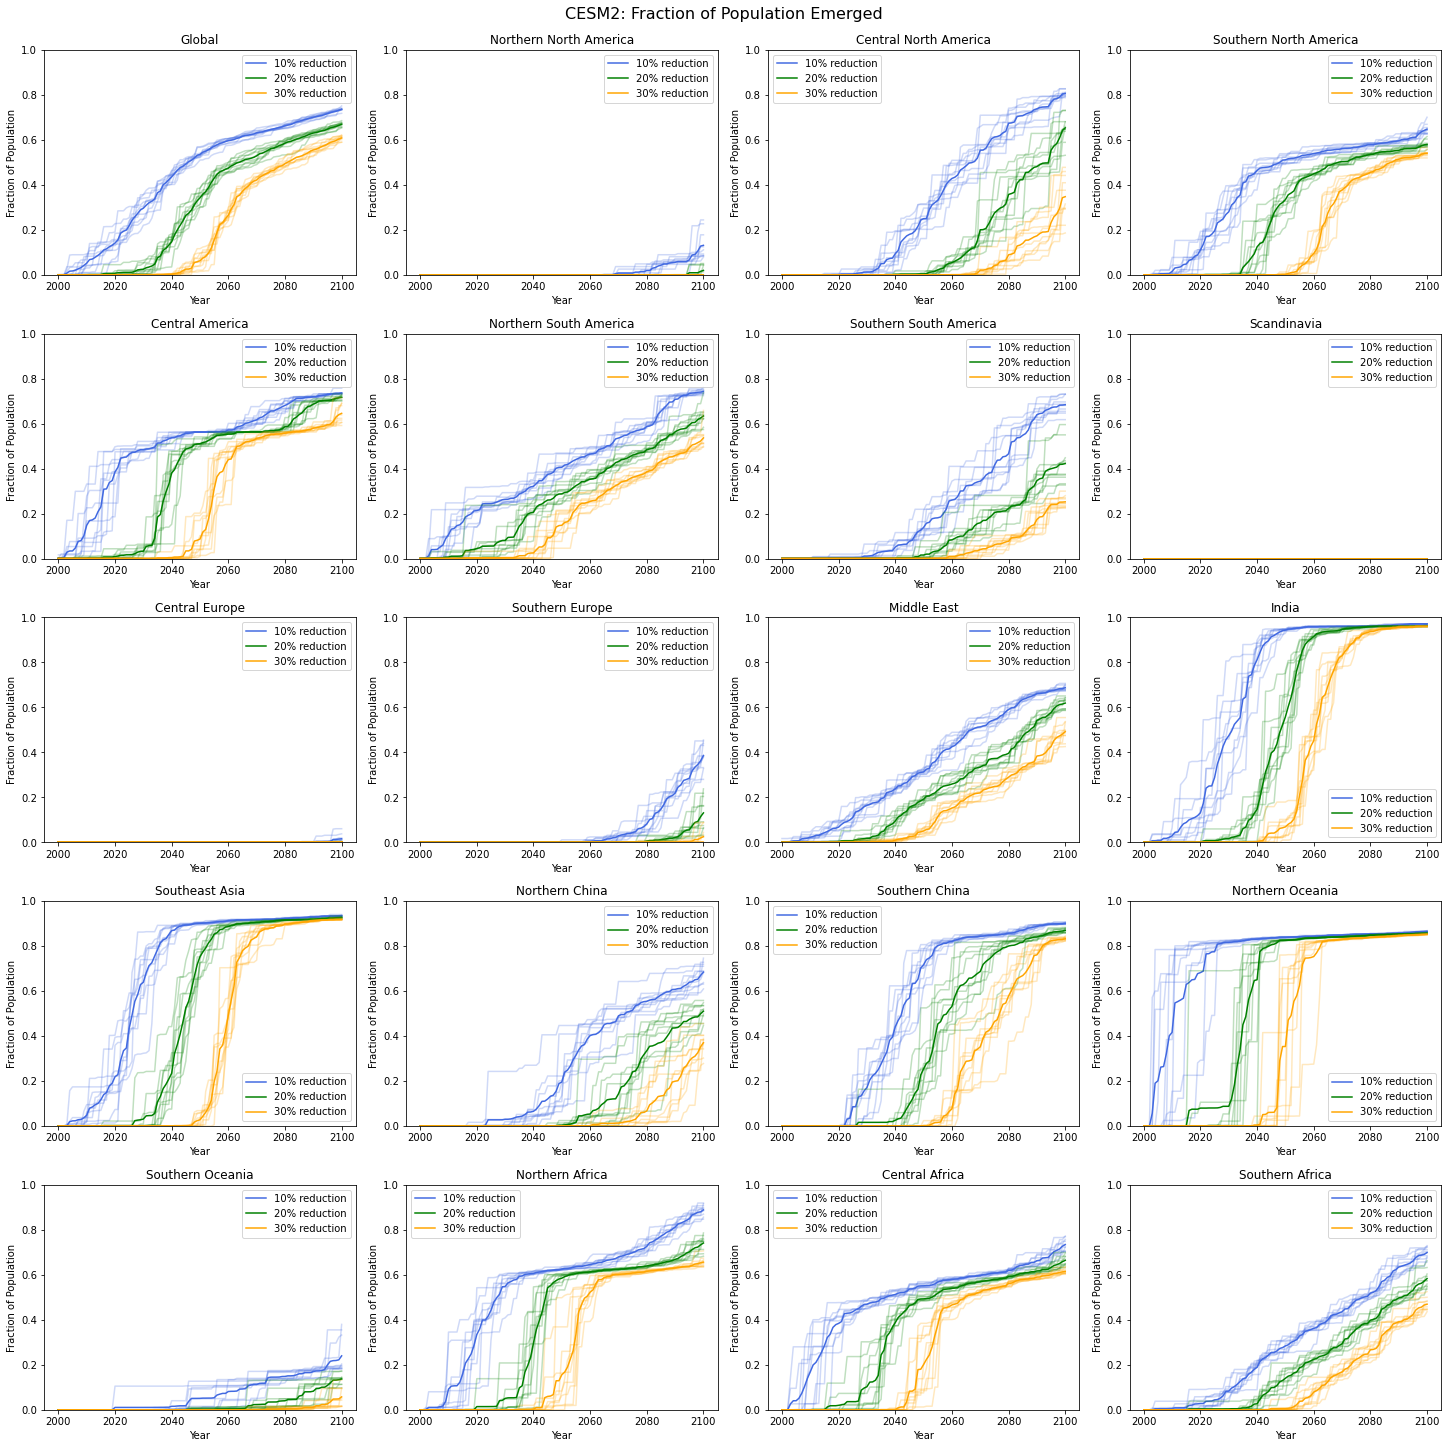

In [66]:
lf.frac_emerge_all(ds_toe,ds_pop,'CESM2','Fraction of Population','CESM2: Fraction of Population Emerged')

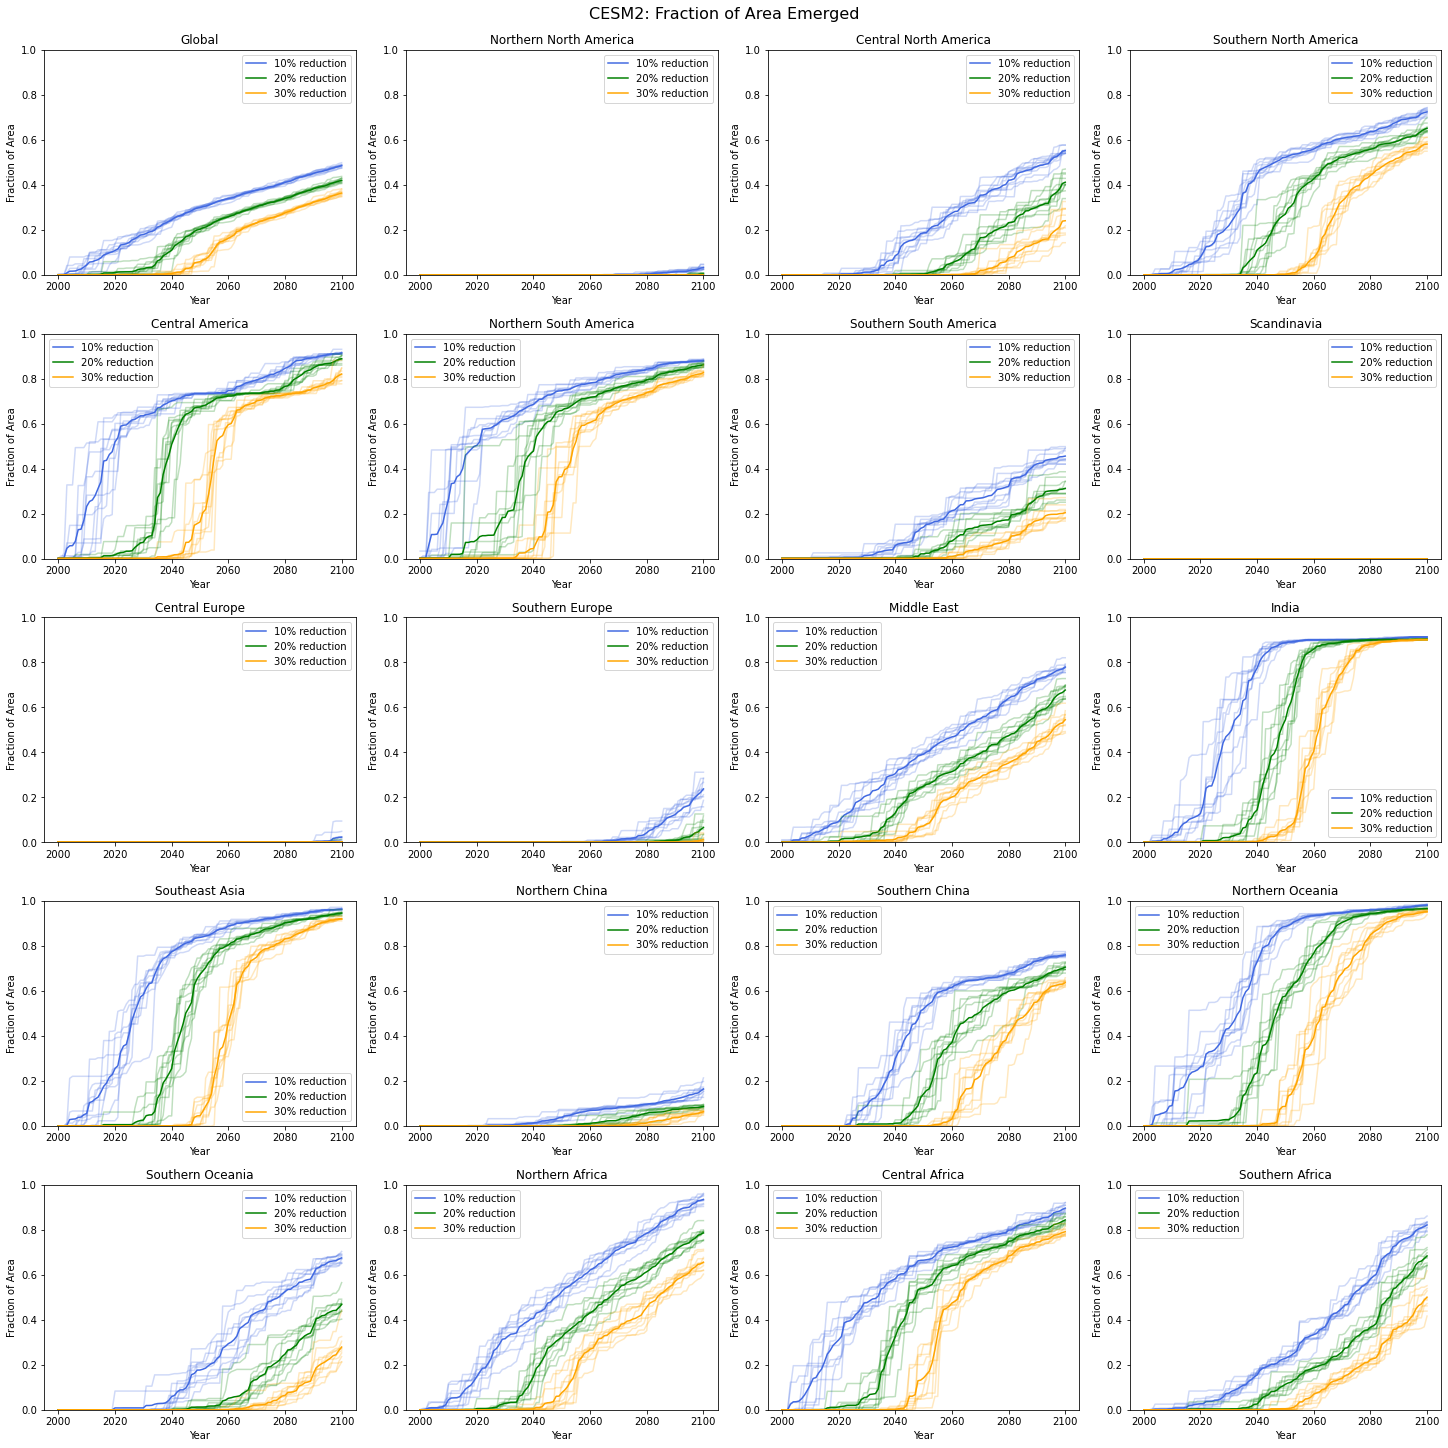

In [67]:
lf.frac_emerge_all(ds_toe,land_area_adj,'CESM2','Fraction of Area','CESM2: Fraction of Area Emerged')

# Monthly Climatology

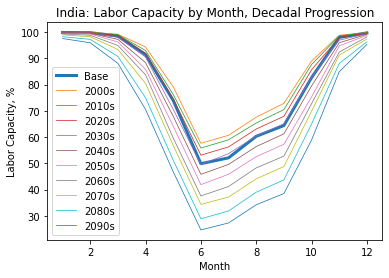

In [37]:
region = 'India'

fig,ax=plt.subplots()

ds_region = lf.slice_region(ds_cesm2,region,'CESM2')
ds_region = ds_region.weighted(ds_pop).mean(['lat','lon','ensemble'])

base_region = lf.slice_region(ds_base,region,'CESM2').weighted(ds_pop).mean(['lat','lon'])
base_region.plot(ax=ax,linewidth=3)

for index in range(0,10):
    ds_decade = ds_region.isel(time=slice(index*120,index*120+120))
    ds_decade.groupby('time.month').mean().plot(ax=ax,linewidth=0.75)
ax.set_xlabel('Month')
ax.set_ylabel('Labor Capacity, %')
ax.set_title(region + ': Labor Capacity by Month, Decadal Progression')
ax.legend(['Base','2000s','2010s','2020s','2030s','2040s','2050s','2060s','2070s','2080s','2090s'])

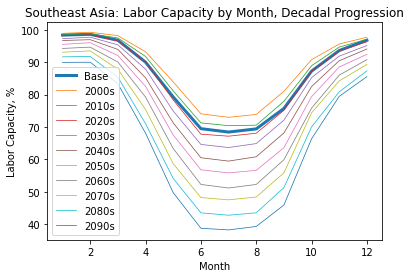

In [68]:
region = 'Southeast Asia'

fig,ax=plt.subplots()

ds_region = lf.slice_region(ds_cesm2,region,'CESM2')
ds_region = ds_region.weighted(ds_pop).mean(['lat','lon','ensemble'])

base_region = lf.slice_region(ds_base,region,'CESM2').weighted(ds_pop).mean(['lat','lon'])
base_region.plot(ax=ax,linewidth=3)

for index in range(0,10):
    ds_decade = ds_region.isel(time=slice(index*120,index*120+120))
    ds_decade.groupby('time.month').mean().plot(ax=ax,linewidth=0.75)
ax.set_xlabel('Month')
ax.set_ylabel('Labor Capacity, %')
ax.set_title(region + ': Labor Capacity by Month, Decadal Progression')
ax.legend(['Base','2000s','2010s','2020s','2030s','2040s','2050s','2060s','2070s','2080s','2090s'])

[########################################] | 100% Completed |  0.1s


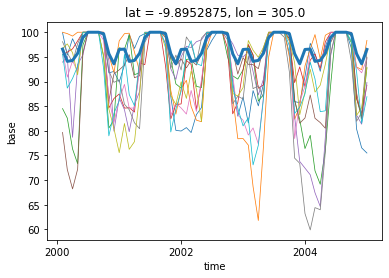

In [65]:
fig,ax=plt.subplots()
with ProgressBar():
    ds = ds_cesm2.sel(lat=-10,lon=300,method='nearest').isel(time=slice(0,60))
    ds.plot.line(hue='ensemble',add_legend=False,ax=ax,linewidth=0.75)
ds_base2 = ds_base.sel(lat=-10,lon=305,method='nearest')
ds['base'] = ds_base2.sel(month=ds['time.month'])
ds['base'].plot(ax=ax,linewidth=3)